In [23]:
import os
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from helpers import util

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIR = '../data'

In [2]:
players = pd.read_csv(join(DATA_DIR, 'raw', 'players.csv'))
attrib_df = pd.read_csv('../results/oline_attribution.csv')

players = util.uncamelcase_columns(players)

In [3]:
attrib_df.head()

,game_play_id,player_id,position,fc_attribution,baseline_fc
0,2022091200_622,41310.0,RG,0.081025,0.765912
1,2022091200_622,43537.0,C,0.060133,0.765912
2,2022091200_622,47907.0,LG,0.092339,0.765912
3,2022091200_622,54474.0,LT,0.096835,0.765912
4,2022091200_622,54537.0,RT,0.025702,0.765912


In [4]:
ol_attrib = (
    attrib_df.merge(
        players[['nfl_id', 'display_name','position']],
        left_on='player_id',
        right_on='nfl_id',
        how='left',
        suffixes=('', '_roster')
    ).groupby('player_id').aggregate({
        'display_name': 'first',
        'position_roster': 'first',
        'fc_attribution': 'mean',
        'position': 'count',
    }).reset_index().sort_values('fc_attribution', ascending=False).rename(columns={
        'position': 'n_plays',
    }).query('n_plays > 80').reset_index(drop=True)
)

ol_attrib.head()

,player_id,display_name,position_roster,fc_attribution,n_plays
0,44870.0,Ethan Pocic,C,0.064443,157
1,43307.0,Ryan Kelly,C,0.060222,109
2,42471.0,Jon Feliciano,C,0.059623,99
3,42371.0,Laken Tomlinson,G,0.058161,113
4,42474.0,Shaquille Mason,G,0.057938,117


In [5]:
ol_attrib.fc_attribution.describe()

count    119.000000
mean       0.047288
std        0.006516
min        0.031482
25%        0.042844
50%        0.046831
75%        0.052290
max        0.064443
Name: fc_attribution, dtype: float64

In [6]:
ol_attrib = (
    ol_attrib.assign(
        fc_attribution_rescaled=lambda x: (
            x.fc_attribution - x.fc_attribution.min() + 0.005
        ) / (x.fc_attribution.max() - x.fc_attribution.min() + 0.005) *.98
    )
)

# 7. Validate results with all pro history

In [7]:
import nfl_data_py as nfl

cols = ['season','pfr_player_name','category','position','allpro','seasons_started','w_av','games']
allpros = (
    nfl.import_draft_picks(years=range(2000,2023))
    .query('category == "OL"')
    [cols]
    .merge(
        nfl.import_seasonal_rosters([2022])
        .query('position == "OL"')
        [['player_name','rookie_year','gsis_it_id','headshot_url']],
        left_on=['pfr_player_name', 'season'],
        right_on=['player_name', 'rookie_year'],
        how='left'
    )
    .assign(
        gsis_it_id=lambda x: x['gsis_it_id'].astype('float'),
    )
)

allpros.head()

,season,pfr_player_name,category,position,allpro,seasons_started,w_av,games,player_name,rookie_year,gsis_it_id,headshot_url
0,2000,Chris Samuels,OL,T,0,9,63.0,141.0,NaN,NaN,NaN,NaN
1,2000,Stockar McDougle,OL,T,0,3,23.0,81.0,NaN,NaN,NaN,NaN
2,2000,Chris McIntosh,OL,T,0,1,8.0,24.0,NaN,NaN,NaN,NaN
3,2000,Travis Claridge,OL,G,0,3,23.0,52.0,NaN,NaN,NaN,NaN
4,2000,Marvel Smith,OL,T,0,7,44.0,111.0,NaN,NaN,NaN,NaN


#### Impute the missing performance data

In [8]:
player_data = {
    "Shaquille Mason": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 67,
        "games": 147
    },
    "Nate Herbig": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 13,
        "games": 61
    },
    "David Andrews": {
        "allpro": 0,
        "seasons_started": 9,
        "w_av": 58,
        "games": 124
    },
    "Evan Brown": {
        "allpro": 0,
        "seasons_started": 6,
        "w_av": 23,
        "games": 74
    },
    "Andrew Norwell": {
        "allpro": 1,
        "seasons_started": 9,
        "w_av": 63,
        "games": 128
    },
    "Matt Feiler": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 47,
        "games": 91
    },
    "Aaron Brewer": {
        "allpro": 0,
        "seasons_started": 3,
        "w_av": 15,
        "games": 75
    },
    "Elijah Wilkinson": {
        "allpro": 0,
        "seasons_started": 6,
        "w_av": 27,
        "games": 79
    },
    "La'el Collins": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 52,
        "games": 89
    },
    "Terence Steele": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 28,
        "games": 79
    },
    "Lloyd Cushenberry": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 22,
        "games": 65
    },
    "Sam Mustipher": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 18,
        "games": 64
    },
    "Alaric Jackson": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 12,
        "games": 41
    },
    "Jon Runyan": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 34,
        "games": 80
    },
    "Charles Leno": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 69,
        "games": 149
    },
    "Jake Brendel": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 20,
        "games": 88
    },
    "Jedrick Wills": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 30,
        "games": 58
    },
    "James Hurst": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 55,
        "games": 150
    },
    "Trenton Brown": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 47,
        "games": 103
    }
}
allpro_missing_vals = pd.DataFrame.from_dict(player_data, orient='index').reset_index().rename(columns={
    'index': 'player_name'
})
allpro_missing_vals

,player_name,allpro,seasons_started,w_av,games
0,Shaquille Mason,0,10,67,147
1,Nate Herbig,0,5,13,61
2,David Andrews,0,9,58,124
3,Evan Brown,0,6,23,74
4,Andrew Norwell,1,9,63,128
5,Matt Feiler,0,7,47,91
6,Aaron Brewer,0,3,15,75
7,Elijah Wilkinson,0,6,27,79
8,La'el Collins,0,7,52,89
9,Terence Steele,0,5,28,79


In [9]:
ol_attrib_final = (
    ol_attrib.merge(
        allpros[['gsis_it_id','allpro','seasons_started','w_av','games','headshot_url']],
        left_on='player_id',
        right_on='gsis_it_id',
        how='left',
    )
    .drop(columns=['gsis_it_id'])
    .merge(
        allpro_missing_vals,
        left_on='display_name',
        right_on='player_name',
        how='left',
        suffixes=('', '_missing')
    )
    .assign(
        allpro=lambda x: x['allpro'].fillna(x['allpro_missing']),
        seasons_started=lambda x: x['seasons_started'].fillna(x['seasons_started_missing']),
        w_av=lambda x: x['w_av'].fillna(x['w_av_missing']),
        games=lambda x: x['games'].fillna(x['games_missing'])
    )
    .drop(columns=['allpro_missing', 'seasons_started_missing', 'w_av_missing', 'games_missing','player_name'])
    .assign(
        allpro_rate=lambda x: x['allpro'] / x['seasons_started']
    )
    .assign(
        allpro_rate=lambda x: x['allpro_rate'].fillna(0),
    )
)
ol_attrib_final.head()

,player_id,display_name,position_roster,fc_attribution,n_plays,fc_attribution_rescaled,allpro,seasons_started,w_av,games,headshot_url,allpro_rate
0,44870.0,Ethan Pocic,C,0.064443,157,0.980000,0.0,4.0,30.0,101.0,https://static.www.nfl.com/image/private/f_aut...,0.0
1,43307.0,Ryan Kelly,C,0.060222,109,0.871035,0.0,9.0,54.0,121.0,https://static.www.nfl.com/image/private/f_aut...,0.0
2,42471.0,Jon Feliciano,C,0.059623,99,0.855582,0.0,2.0,26.0,113.0,https://static.www.nfl.com/image/private/f_aut...,0.0
3,42371.0,Laken Tomlinson,G,0.058161,113,0.817839,0.0,10.0,54.0,163.0,https://static.www.nfl.com/image/private/f_aut...,0.0
4,42474.0,Shaquille Mason,G,0.057938,117,0.812085,0.0,10.0,67.0,147.0,NaN,0.0


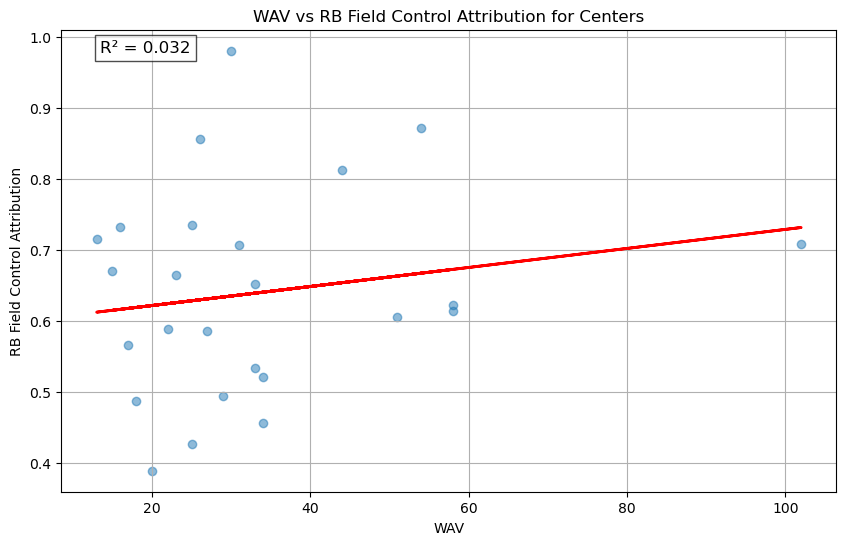

In [10]:
position = 'C'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Centers')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

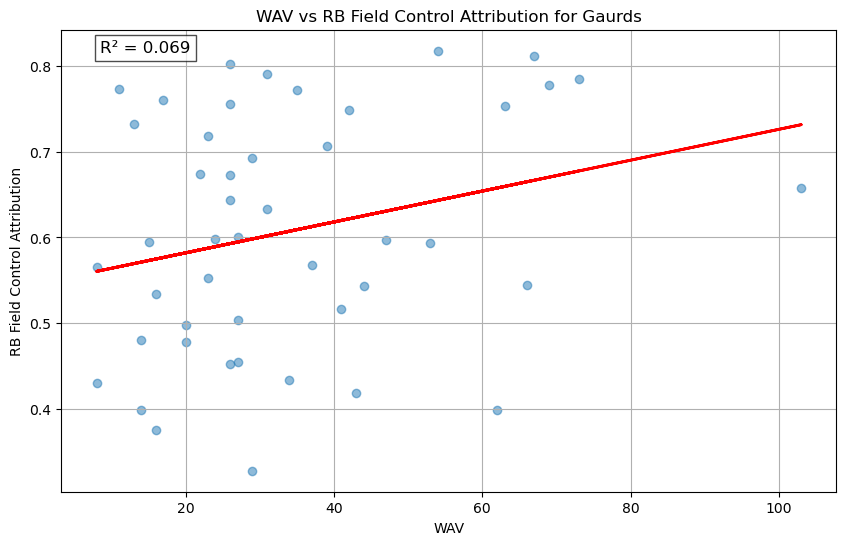

In [11]:
position = 'G'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Gaurds')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

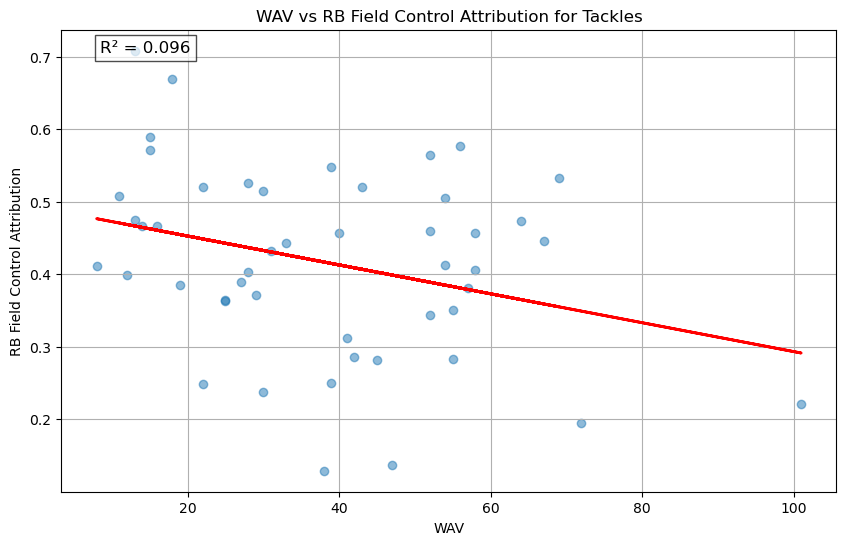

In [12]:
position = 'T'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Tackles')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

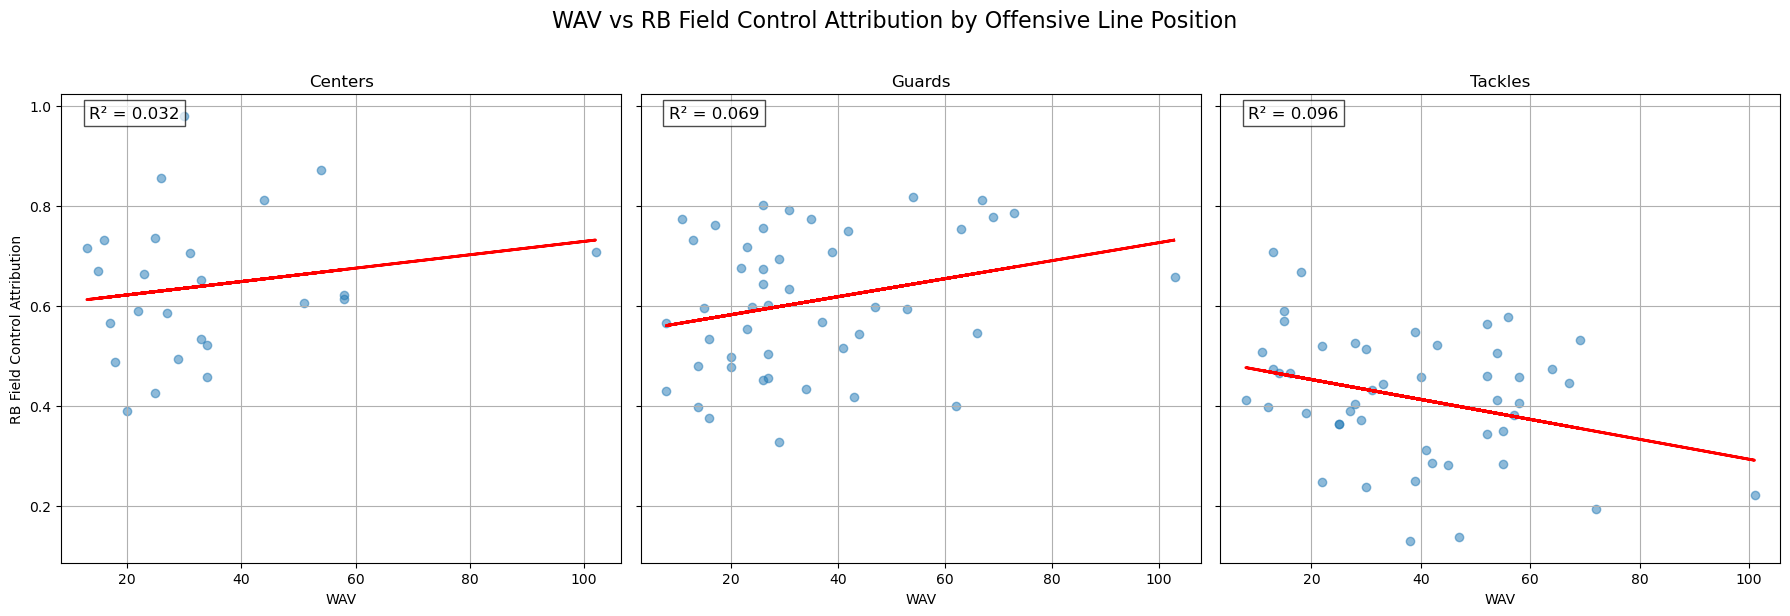

In [13]:
import matplotlib.pyplot as plt
import numpy as np

positions = ['C', 'G', 'T']
position_names = {'C': 'Centers', 'G': 'Guards', 'T': 'Tackles'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, position in zip(axes, positions):
    grouped_attrib = ol_attrib_final.query('position_roster == @position')
    x = grouped_attrib['w_av']
    y = grouped_attrib['fc_attribution_rescaled']
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.5)
    
    # Best fit line
    coeffs = np.polyfit(x, y, 1)
    fit_line = np.poly1d(coeffs)(x)
    ax.plot(x, fit_line, color='red', linewidth=2, label='Best Fit Line')
    
    # R² calculation
    r2 = np.corrcoef(x, y)[0, 1] ** 2
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(position_names[position])
    ax.set_xlabel('WAV')
    if position == 'C':
        ax.set_ylabel('RB Field Control Attribution')
    ax.grid(True)

fig.suptitle('WAV vs RB Field Control Attribution by Offensive Line Position', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# 8. Save the data

In [14]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
center_attribution = (
    ol_attrib_final.query('position_roster == "C"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
)
center_attribution.to_csv('center_attribution.csv', index=False)

In [15]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
gaurd_attribution = (
    ol_attrib_final.query('position_roster == "G"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
)
gaurd_attribution.to_csv('gaurd_attribution.csv', index=False)

In [16]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
tackle_attribution = (
    ol_attrib_final.query('position_roster == "T"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
)

tackle_attribution.to_csv('tackle_attribution.csv', index=False)

In [17]:
players = pd.read_csv(join(DATA_DIR, 'raw', 'players.csv'))
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [18]:
import nfl_data_py as nfl

headshots = (
    nfl.import_seasonal_rosters([2022])
    [['team','gsis_it_id','position','depth_chart_position','headshot_url']]
    .query('position == "OL"')
    .drop('position', axis=1)
)

cols = ['team', 'headshot_url', 'Player',
       'WAV', 'N Plays', 'FCA']

tackles = (
    players.merge(
        headshots.assign(
            gsis_it_id=lambda x: x['gsis_it_id'].astype('float')
        ),
        left_on='nflId',
        right_on='gsis_it_id',
        how='inner'
    ).drop(columns=['gsis_it_id'])
    .merge(
        tackle_attribution,
        left_on='displayName',
        right_on='Player',
        how='inner'
    )
)[cols]

centers = (
    players.merge(
        headshots.assign(
            gsis_it_id=lambda x: x['gsis_it_id'].astype('float')
        ),
        left_on='nflId',
        right_on='gsis_it_id',
        how='inner'
    ).drop(columns=['gsis_it_id'])
    .merge(
        center_attribution,
        left_on='displayName',
        right_on='Player',
        how='inner'
    )
    .query('position == "C"')
)[cols]

guards = (
    players.merge(
        headshots.assign(
            gsis_it_id=lambda x: x['gsis_it_id'].astype('float')
        ),
        left_on='nflId',
        right_on='gsis_it_id',
        how='inner'
    ).drop(columns=['gsis_it_id'])
    .merge(
        gaurd_attribution,
        left_on='displayName',
        right_on='Player',
        how='inner'
    )
    .query('position == "G"')
)[cols]

In [19]:
guards.head()

,team,headshot_url,Player,WAV,N Plays,FCA
0,BAL,https://static.www.nfl.com/image/private/f_aut...,Kevin Zeitler,66.0,122,54.5
1,DAL,https://static.www.nfl.com/image/private/f_aut...,Zack Martin,103.0,141,65.7
2,CLE,https://static.www.nfl.com/image/private/f_aut...,Joel Bitonio,73.0,157,78.5
3,WAS,https://static.www.nfl.com/image/private/f_aut...,Andrew Norwell,63.0,108,75.4
4,LAC,https://static.www.nfl.com/image/private/f_aut...,Matt Feiler,47.0,92,59.8


In [161]:
import requests
from io import BytesIO
from PIL import Image

guards_t20 = (
    guards
    .sort_values('FCA', ascending=False)
    .reset_index(drop=True)
    .head(20)
)

guards_t20.insert(0, "Rank", range(1, len(guards_t20) + 1))
guards_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)

def download_image(url, save_path, playername, team):
    try:
        filename = f"{playername.replace(' ', '_').replace('.', '')}_{team}.png"
        filepath = os.path.join(save_path, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            print(f"Skipped {filepath} - already exists")
            return

        # Download
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        # Get background color (top-left pixel)
        datas = img.getdata()
        new_data = []
        bg_color = datas[0]  # likely green screen background

        for item in datas:
            # Match background color exactly (RGB only)
            if item[:3] == bg_color[:3]:
                new_data.append((255, 255, 255, 0))  # transparent
            else:
                new_data.append(item)

        img.putdata(new_data)
        img.save(filepath, format="PNG")
        print(f"Downloaded and saved transparent image to {filepath}")

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")


for row in guards_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.Player,
        row.team
    )

guards_t20['headshot_path'] = guards_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.Player.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

guards_t20['team_logo_path'] = guards_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)


Skipped ../data/images/headshots/Laken_Tomlinson_NYJ.png - already exists
Skipped ../data/images/headshots/Shaquille_Mason_TB.png - already exists
Skipped ../data/images/headshots/Michael_Onwenu_NE.png - already exists
Skipped ../data/images/headshots/Landon_Dickerson_PHI.png - already exists
Skipped ../data/images/headshots/Joel_Bitonio_CLE.png - already exists
Skipped ../data/images/headshots/Quenton_Nelson_IND.png - already exists
Skipped ../data/images/headshots/Isaac_Seumalo_PHI.png - already exists
Skipped ../data/images/headshots/Cole_Strange_NE.png - already exists
Skipped ../data/images/headshots/Luke_Goedeke_TB.png - already exists
Skipped ../data/images/headshots/Austin_Corbett_CAR.png - already exists
Skipped ../data/images/headshots/Andrew_Norwell_WAS.png - already exists
Skipped ../data/images/headshots/Alex_Cappa_CIN.png - already exists
Skipped ../data/images/headshots/Nate_Herbig_NYJ.png - already exists
Skipped ../data/images/headshots/Isaiah_Wynn_NE.png - already exi

In [180]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def circled_image(
    ax: plt.Axes, 
    path: str, 
    *,
    bg_circle: bool = False,
    bg_circle_kwargs: dict = None,
    zoom: float = 0.9,
    **imshow_kwargs
):
    """Plots an image cropped to a circle, aligned to cell center."""
    img = plt.imread(path)

    # Crop the image to be a perfect square
    h, w, _ = img.shape
    if h != w:
        min_dim = min(h, w)
        start_h = (h - min_dim) // 2
        start_w = (w - min_dim) // 2
        img = img[start_h:start_h + min_dim, start_w:start_w + min_dim, :]

    # Normalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # Background circle
    if bg_circle:
        bg_kw = {
            "facecolor": "lightgray",
            "edgecolor": "none",
            "zorder": 0
        }
        if bg_circle_kwargs:
            bg_kw.update(bg_circle_kwargs)
        ax.add_patch(Circle((0.5, 0.5), 0.5 * zoom, **bg_kw))

    # Plot image
    im = ax.imshow(img, extent=(0, 1, 0, 1), **imshow_kwargs)

    # Clip to circle
    clip_circle = Circle((0.5, 0.5), 0.5 * zoom, transform=ax.transData)
    im.set_clip_path(clip_circle)

    return im

def regular_image(
    ax: plt.Axes,
    path: str,
    *,
    zoom: float = 0.9,
    **imshow_kwargs
):
    """Plots an image without cropping, aligned to cell center."""
    img = plt.imread(path)

    # Normalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # Plot image
    im = ax.imshow(img, extent=(0, 1, 0, 1), **imshow_kwargs)

    return im

/Users/lukeneuendorf/miniforge3/envs/nfl-oline/lib/python3.11/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


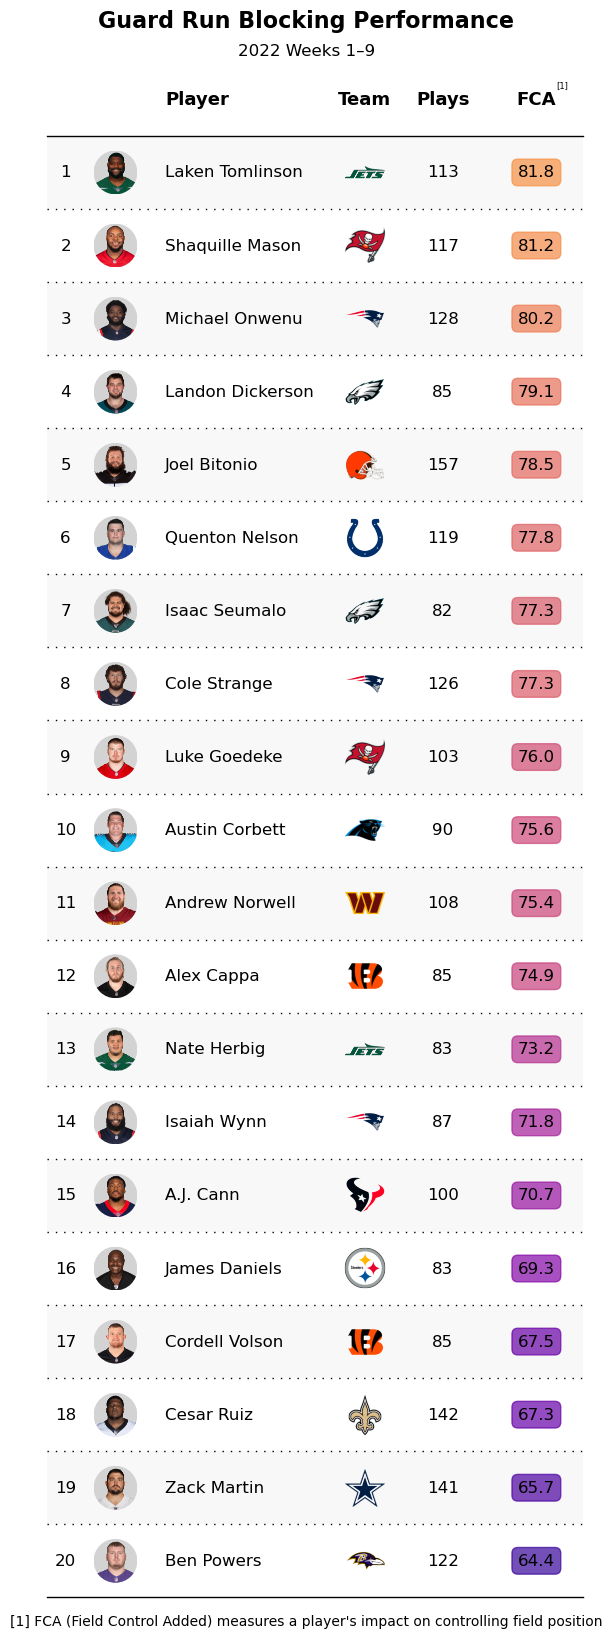

In [189]:
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="N Plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="FCA",
        title="FCA",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(guards["FCA"], cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 20))

cols = ["headshot_path", "Player", "team_logo_path", "N Plays", "FCA"]

table = Table(
    guards_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Guard Run Blocking Performance",
    fontsize=16,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.885,  # Position just below main title
    "2022 Weeks 1–9",
    fontsize=12,
    ha="center", va="center"
)

fig.text(
    0.5, 0.1,
    "[1] FCA (Field Control Added) measures a player's impact on controlling field position",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.865, 0.868,
    "[1]",
    ha="center", va="center", fontsize=6
)

# save image to ../results/oline_run_blocking_grades/guards_t20.png
os.makedirs('../results/oline_run_blocking_grades', exist_ok=True)
plt.savefig('../results/oline_run_blocking_grades/guards_t20.png', bbox_inches='tight', dpi=300)

plt.show()